In [30]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sms
import datetime
import statsmodels.api as sm


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer


In [17]:
df = pd.read_excel("data.xlsx")

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4417 entries, 0 to 4416
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date/Time      4417 non-null   datetime64[ns]
 1   Constraint DA  4417 non-null   float64       
 2   Constraint RT  4417 non-null   float64       
 3   Wind           4417 non-null   float64       
 4   Solar          4417 non-null   float64       
 5   AEP Load       4417 non-null   int64         
 6   ATSI Load      4417 non-null   int64         
 7   COMED Load     4417 non-null   int64         
 8   DOM Load       4417 non-null   int64         
 9   hour           4417 non-null   int64         
 10  day_of_week    4417 non-null   int64         
 11  month          4417 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(6), object(1)
memory usage: 414.2+ KB


In [18]:
df.isna().sum()

Date/Time        0
Constraint DA    0
Constraint RT    0
Wind             5
Solar            1
AEP Load         0
ATSI Load        0
COMED Load       0
DOM Load         0
dtype: int64

In [19]:
df = df.fillna(method='ffill')

In [20]:
df.isna().sum()


Date/Time        0
Constraint DA    0
Constraint RT    0
Wind             0
Solar            0
AEP Load         0
ATSI Load        0
COMED Load       0
DOM Load         0
dtype: int64

In [21]:
# Feature Engineering
df['hour'] = df['Date/Time'].dt.hour
df['day_of_week'] = df['Date/Time'].dt.dayofweek
df["month"] = df["Date/Time"].dt.month_name()

In [22]:
df.head()

Date/Time  Constraint DA  Constraint RT     Wind  Solar  AEP Load  \
0 2021-07-01 01:00:00            0.0            0.0  753.281    0.0     14236   
1 2021-07-01 02:00:00            0.0            0.0  738.755    0.0     13636   
2 2021-07-01 03:00:00            0.0            0.0  724.276    0.0     13171   
3 2021-07-01 04:00:00            0.0            0.0  752.041    0.0     12962   
4 2021-07-01 05:00:00            0.0            0.0  759.611    0.0     13060   

   ATSI Load  COMED Load  DOM Load  hour  day_of_week month  
0       7455       11651     14123     1            3  July  
1       7091       10871     13345     2            3  July  
2       6850       10313     12765     3            3  July  
3       6714        9925     12393     4            3  July  
4       6730        9731     12293     5            3  July

In [23]:
df.describe()

Constraint DA  Constraint RT         Wind        Solar      AEP Load  \
count    4417.000000    4417.000000  4417.000000  4417.000000   4417.000000   
mean      -38.573711     -49.394247  2757.547343   753.184830  14565.183835   
std       115.701292     216.464412  2008.500334   963.148803   2355.529217   
min     -1737.120000   -1920.610000   119.755000     0.000000   9200.000000   
25%         0.000000       0.000000  1123.795000     0.000000  12930.000000   
50%         0.000000       0.000000  2220.221000    22.752000  14203.000000   
75%         0.000000       0.000000  4054.887000  1558.308000  15947.000000   
max         0.000000       0.000000  9110.341000  3138.696000  22122.000000   

          ATSI Load    COMED Load      DOM Load         hour  day_of_week  
count   4417.000000   4417.000000   4417.000000  4417.000000  4417.000000  
mean    7671.254471  11293.011320  12668.480190    11.497849     3.006566  
std     1380.445211   2476.481713   2492.093186     6.923662     1.991195  
min     5201.000000   7346.000000   8425.000000     0.000000     0.000000  
25%     6668.000000   9492.000000  10914.000000     5.000000     1.000000  
50%     7443.000000  10762.000000  12135.000000    11.000000     3.000000  
75%     8345.000000  12353.000000  14010.000000    17.000000     5.000000  
max    12796.000000  20388.000000  20213.000000    23.000000     6.000000

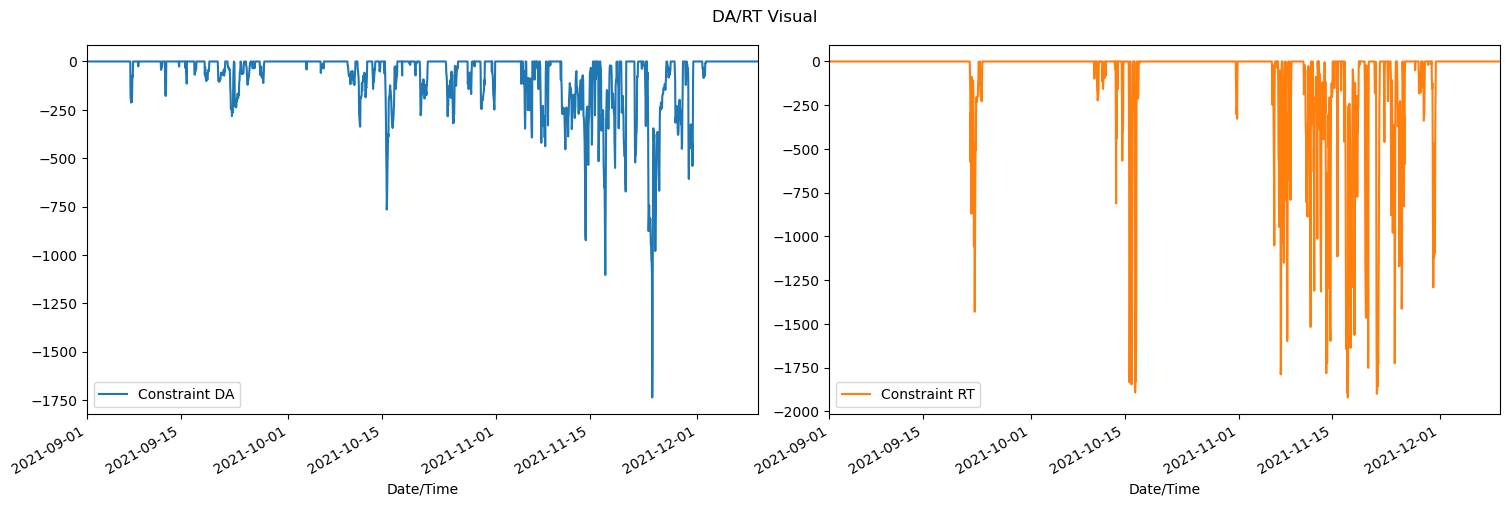

In [24]:
df['Date/Time'] = pd.to_datetime(df['Date/Time'])

load_cols = ['Constraint DA', 'Constraint RT']

df.set_index('Date/Time')[load_cols].plot(subplots=True, layout=(-1, 2), figsize=(15, 5), title="DA/RT Visual")
plt.tight_layout()

start_date = datetime.datetime(2021, 9, 1)
end_date = datetime.datetime(2021, 12, 10)
plt.xlim([start_date, end_date])

plt.show()


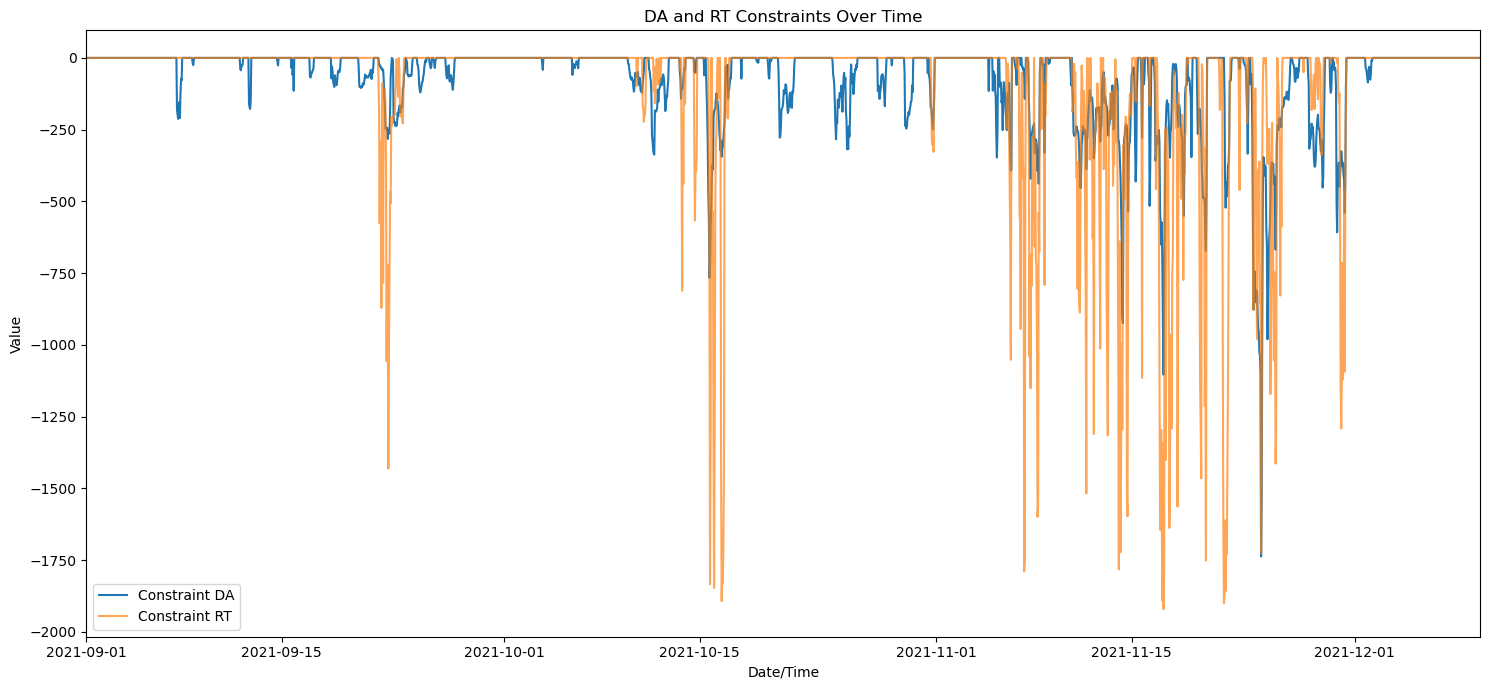

In [25]:
plt.figure(figsize=(15, 7))
plt.plot(df['Date/Time'], df['Constraint DA'], label='Constraint DA')
plt.plot(df['Date/Time'], df['Constraint RT'], label='Constraint RT', alpha=0.7)
plt.title('DA and RT Constraints Over Time')
plt.xlabel('Date/Time')
plt.ylabel('Value')
plt.legend(loc='best')
start_date = datetime.datetime(2021, 9, 1)
end_date = datetime.datetime(2021, 12, 10)
plt.xlim([start_date, end_date])
plt.tight_layout()
plt.show()


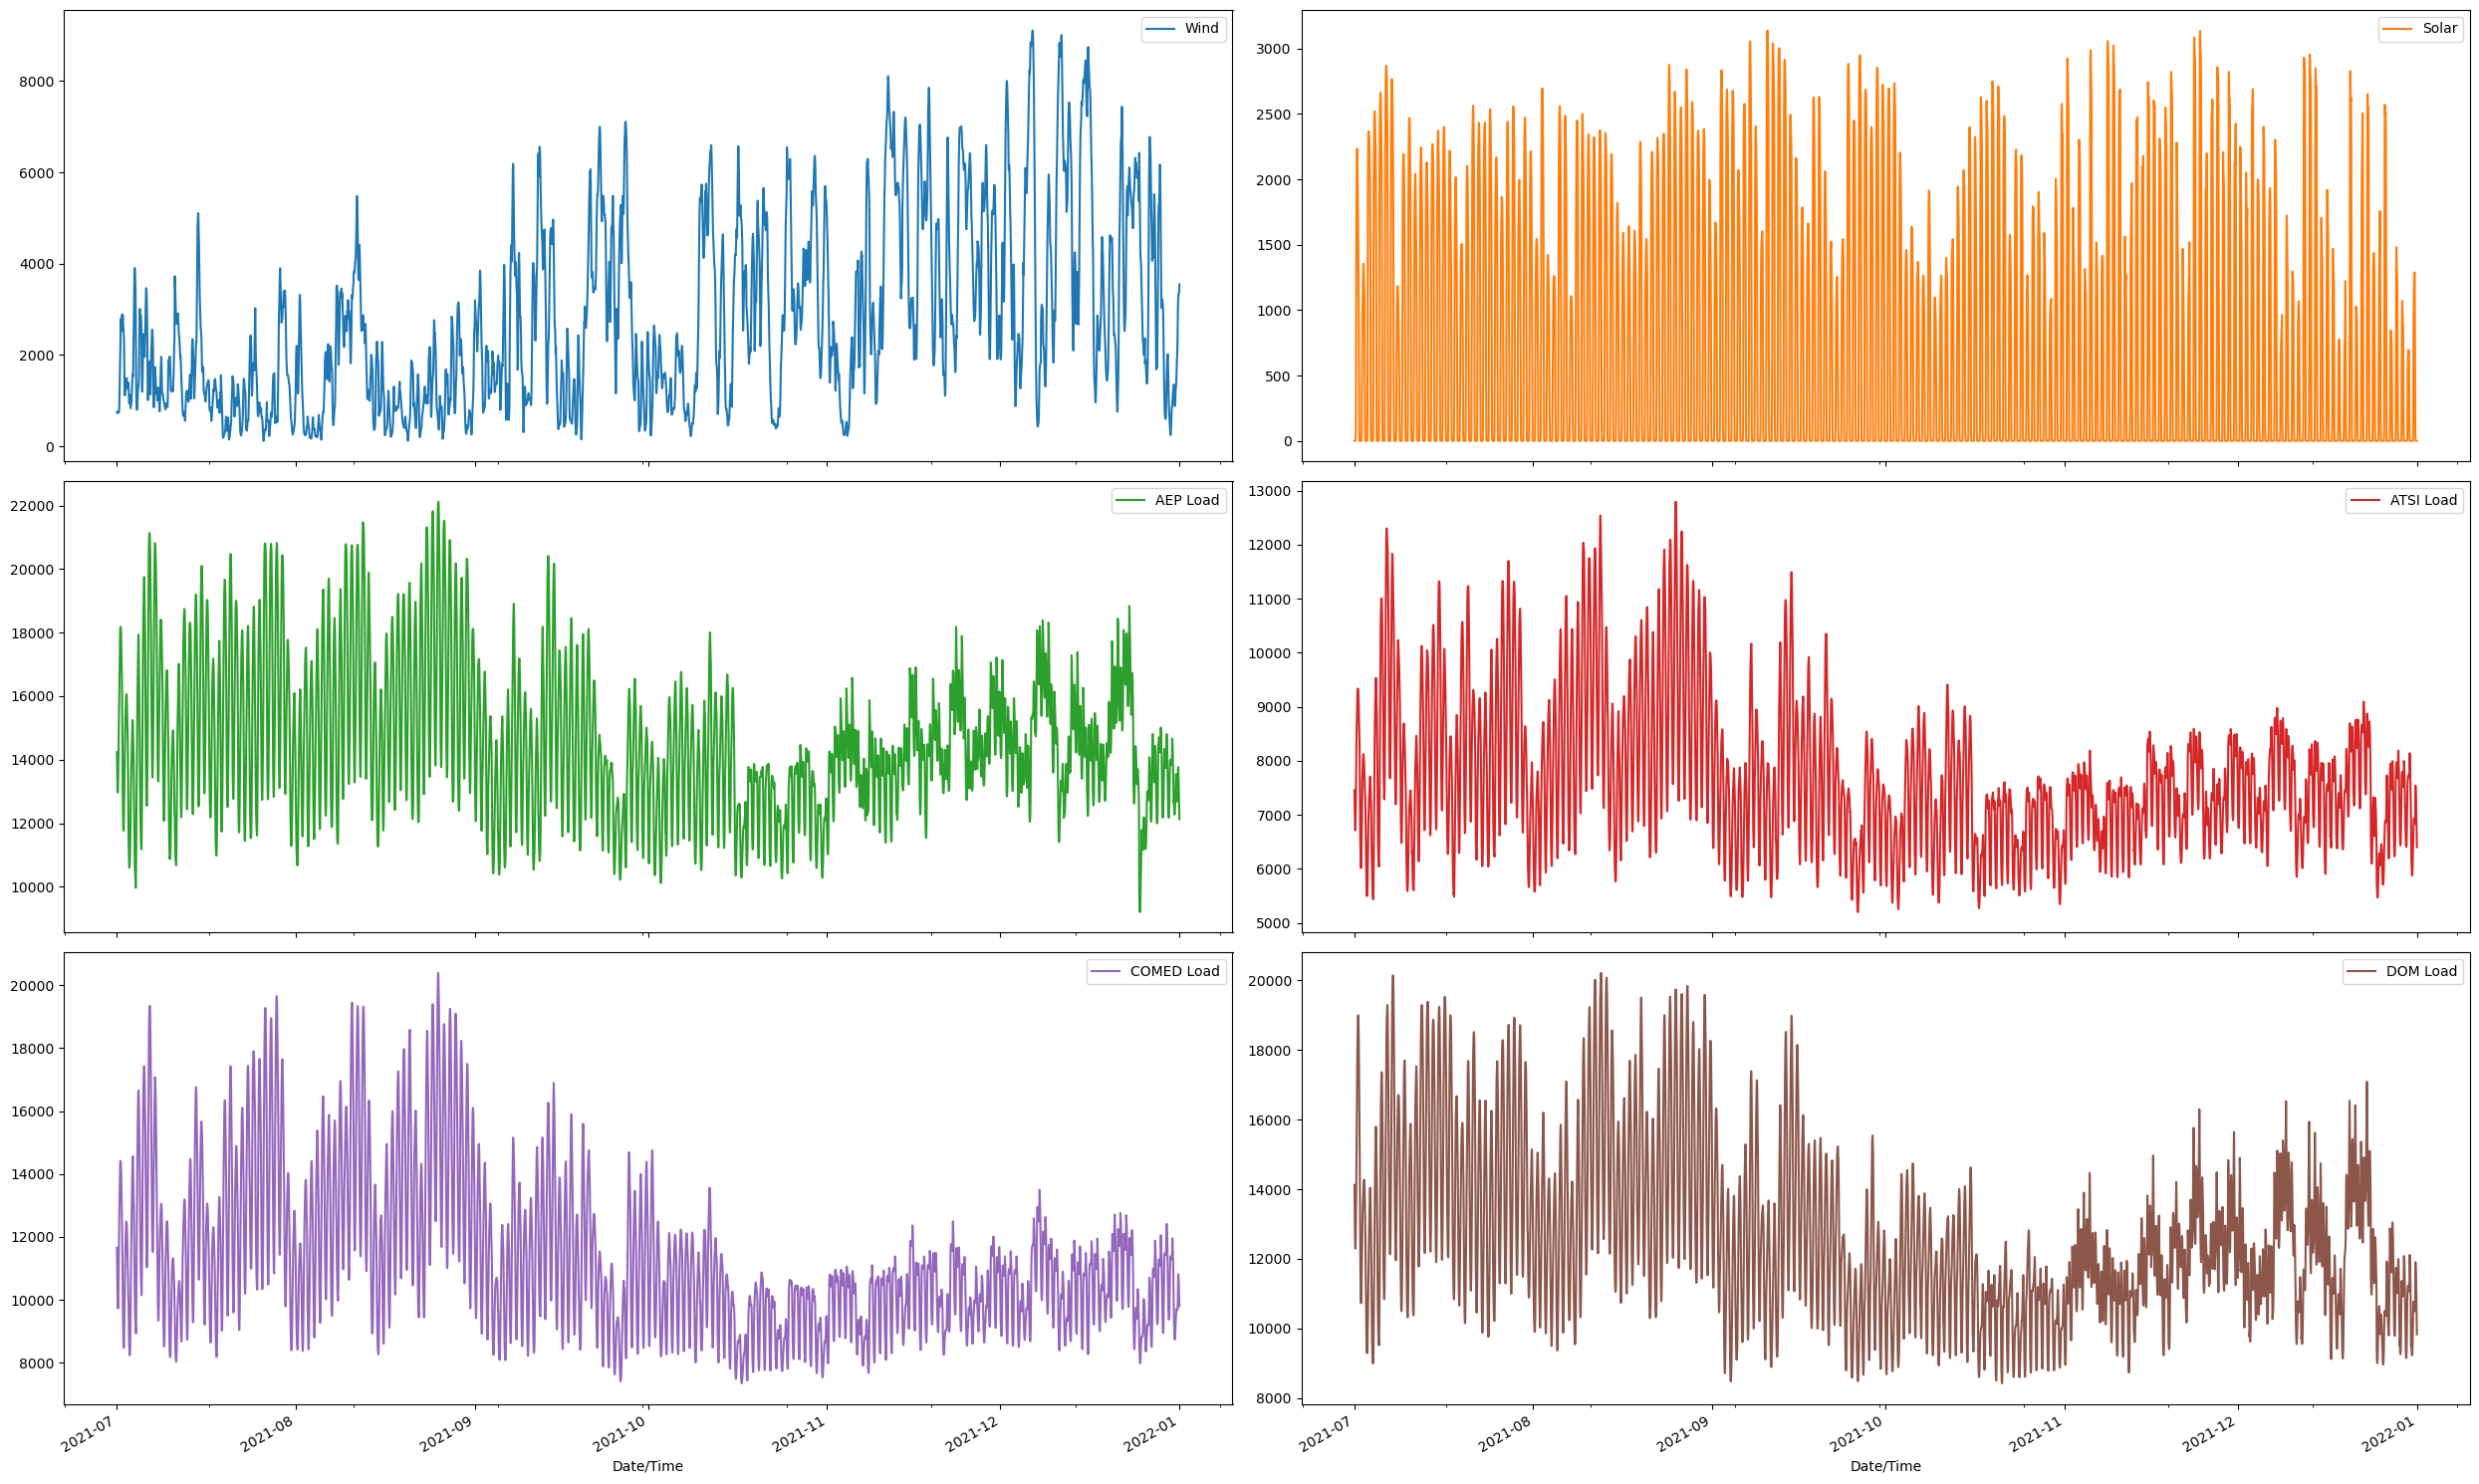

In [26]:
load_cols = ['Wind', 'Solar', 'AEP Load', 'ATSI Load', 'COMED Load', 'DOM Load']

df.set_index('Date/Time')[load_cols].plot(subplots=True, layout=(-1, 2), figsize=(25, 15))

plt.tight_layout()
plt.show()


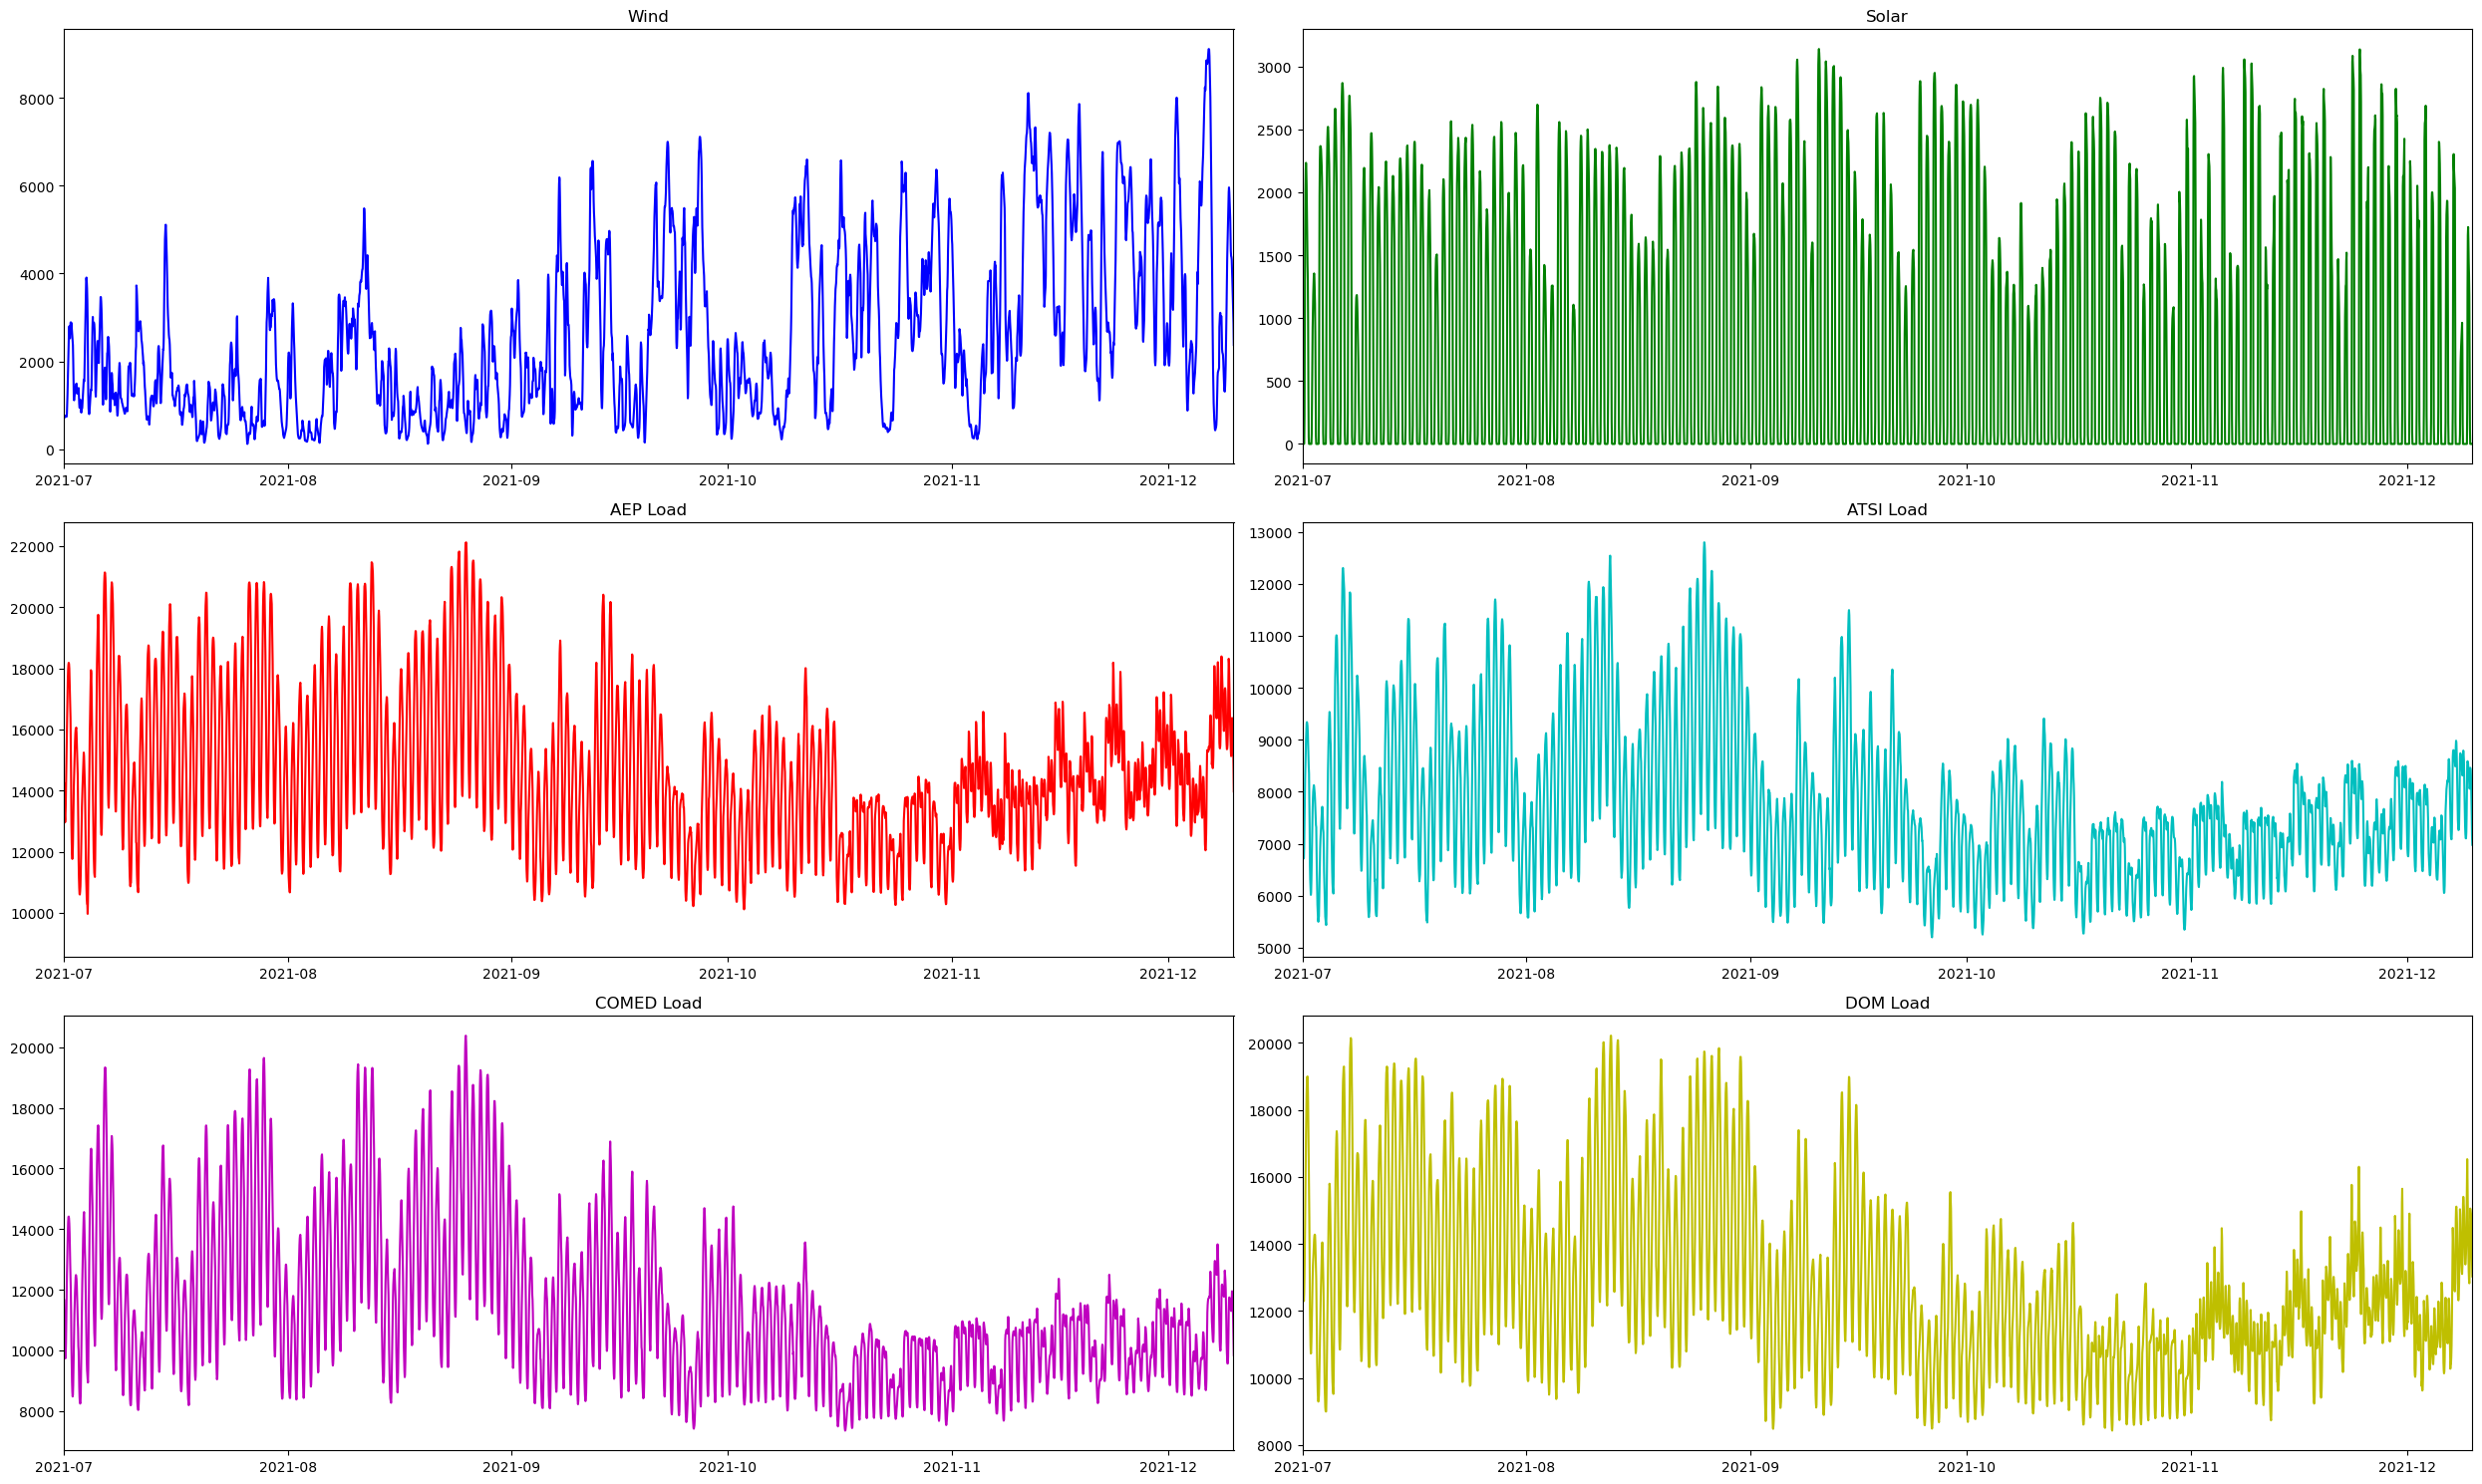

In [27]:
load_cols = ['Wind', 'Solar', 'AEP Load', 'ATSI Load', 'COMED Load', 'DOM Load']

colors = ['b', 'g', 'r', 'c', 'm', 'y']

fig, axs = plt.subplots(len(load_cols)//2, 2, figsize=(25, 15))  # Create a grid of 
axs = axs.ravel()  # Flatten the grid into a 1D array to iterate over

start_date = datetime.datetime(2021, 7, 1)
end_date = datetime.datetime(2021, 12, 10)

for i, col in enumerate(load_cols):
    axs[i].plot(df['Date/Time'], df[col], color=colors[i % len(colors)])  # Use a different color for each plot
    axs[i].set_title(col)  # Set the title for each subplot
    axs[i].set_xlim([start_date, end_date])  # Set the x-axis limits for each subplot

plt.tight_layout()
plt.show()


## Other Plots

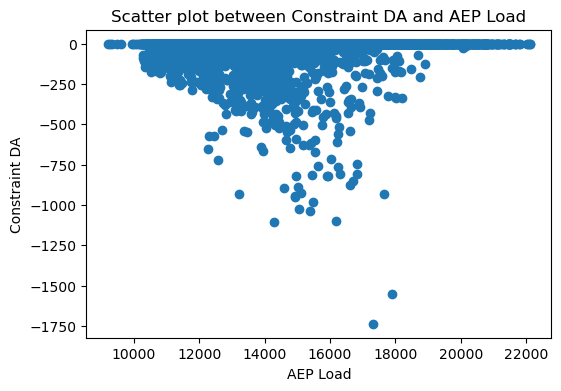

In [28]:
# Create a scatter plot for 'Constraint DA' and 'AEP Load'
plt.figure(figsize=(6, 4))
plt.scatter(df['AEP Load'], df['Constraint DA'])
plt.xlabel('AEP Load')
plt.ylabel('Constraint DA')
plt.title('Scatter plot between Constraint DA and AEP Load')
plt.show()


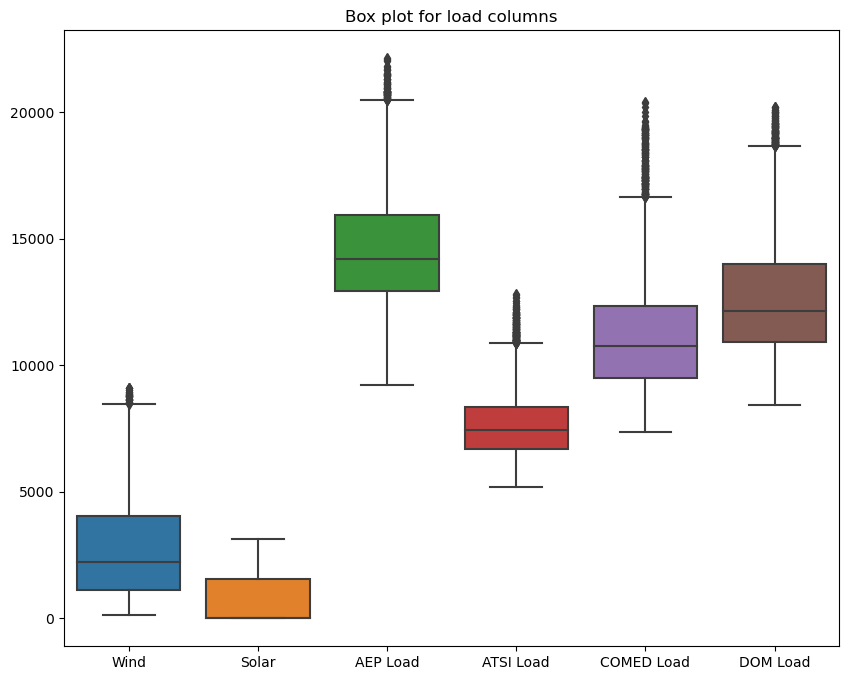

In [31]:
# Boxplot for load columns
plt.figure(figsize=(10, 8))
sms.boxplot(data=df[load_cols])
plt.title('Box plot for load columns')
plt.show()


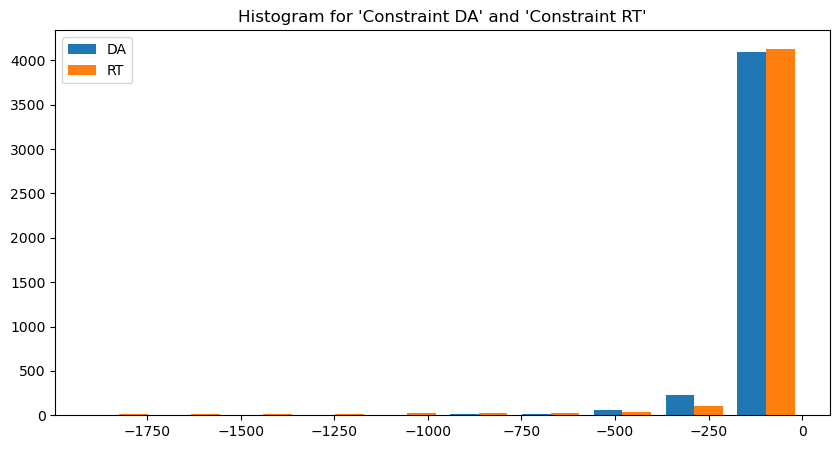

In [ ]:
# Histogram for 'Constraint DA' and 'Constraint RT'
plt.figure(figsize=(10, 5))
plt.hist(df[['Constraint DA', 'Constraint RT']])
plt.legend(["DA", "RT"])
plt.title("Histogram for 'Constraint DA' and 'Constraint RT'")
plt.show()


C:\Users\William Hazen\AppData\Local\Temp\ipykernel_11280\517219142.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


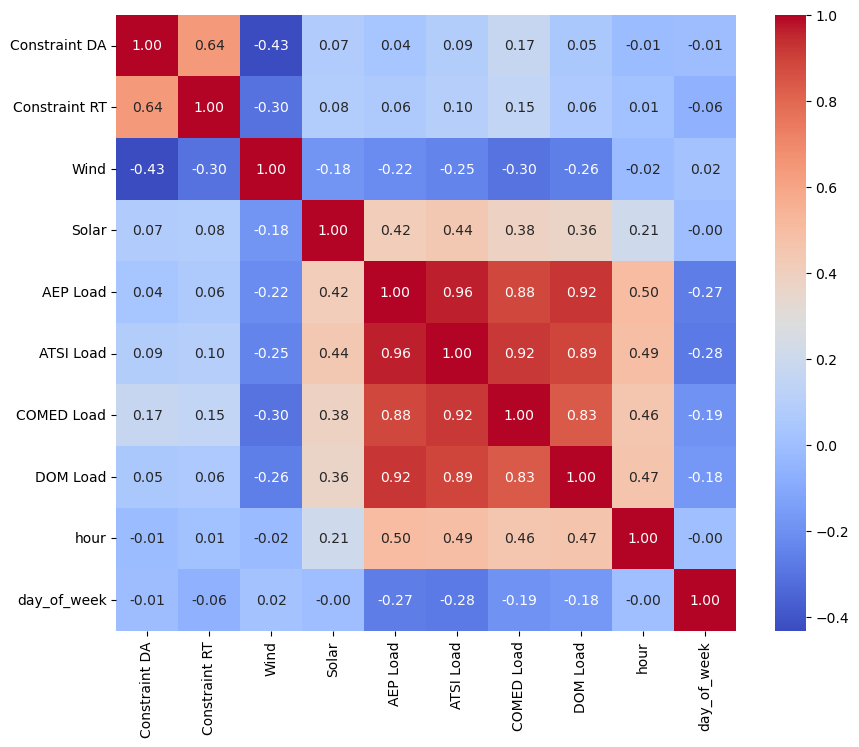

In [33]:
corr = df.corr()
plt.figure(figsize=(10, 8))
sms.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()


# Testing for Stationarity

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
# Ho: It is non stationary
# H1: It is stationary
def adfuller_test(sales):
    result = adfuller(sales)
    labels = ['ADF Test Statistic', 'p-value',
              '#Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(label+' : '+str(value))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary")


In [ ]:
adfuller_test(df['Constraint DA'])


ADF Test Statistic : -6.610039001653793
p-value : 6.411176517556501e-09
#Lags Used : 31
Number of Observations Used : 4385
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [ ]:
adfuller_test(df['Constraint RT'])

ADF Test Statistic : -7.707404867001107
p-value : 1.2906000226292755e-11
#Lags Used : 29
Number of Observations Used : 4387
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


- It appears that for both constraints (DA/RT) are stationary timeseries. This indicated that one whose properties do not depend on the time at which the series is observe.

- However, when looking that the plots. DA and RT only show non-zero values between September to December. Not sure the reason for this but it could be related to seasonal relationships - indicating non startionary timeseries

# Differencing 

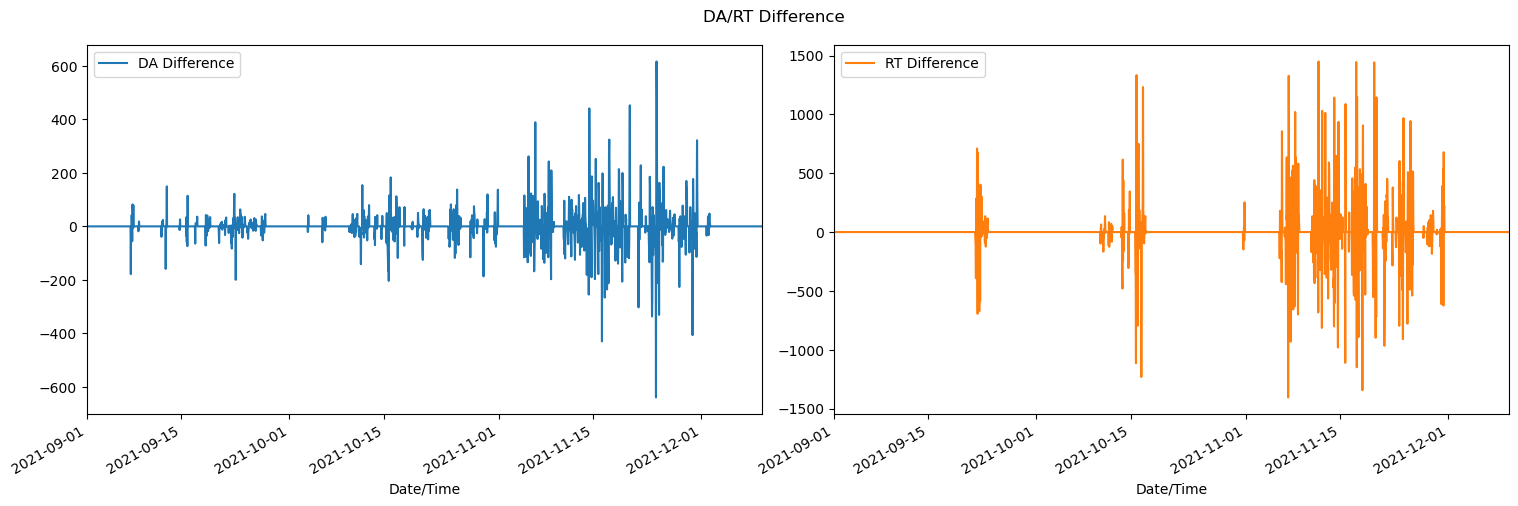

In [ ]:
df['DA Difference'] = df['Constraint DA'] - df['Constraint DA'].shift(1)
df['RT Difference'] = df['Constraint RT'] - df['Constraint RT'].shift(1)

load_cols = ['DA Difference', 'RT Difference']

df.set_index('Date/Time')[load_cols].plot(subplots=True,
                                          layout=(-1, 2), figsize=(15, 5), title="DA/RT Difference")
plt.tight_layout()

start_date = datetime.datetime(2021, 9, 1)
end_date = datetime.datetime(2021, 12, 10)
plt.xlim([start_date, end_date])

plt.show()


# AR Model

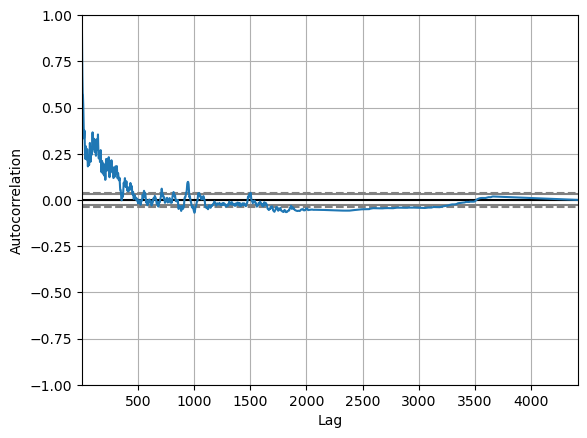

In [ ]:
pd.plotting.autocorrelation_plot(df['Constraint DA'])
plt.show()


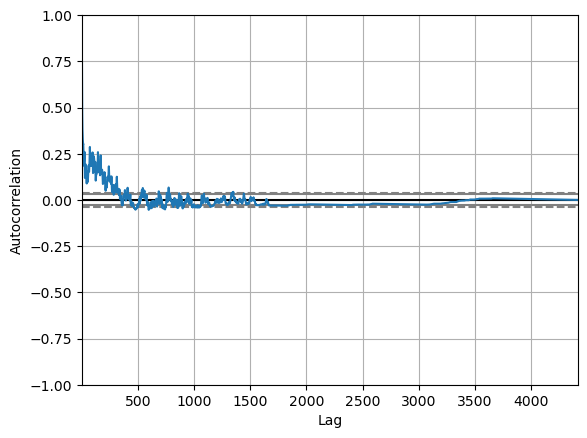

In [ ]:
pd.plotting.autocorrelation_plot(df['Constraint RT'])
plt.show()
